This is an expiremental notebook where you can specify a dataframe path and see how fastText performs on the dataset.

The dataset will remove issues made by detected bots, and additional bots can be added as well. 

Each label is predicted as a fastText binary classification task. Negative samples are evenly distributed amongst other labels.

The output will be a dataframe with the precision, accuracy, and recall for each label, computed using k-fold cross validation.

In [1]:
import pandas as pd
import numpy as np
from skift import FirstColFtClassifier
import itertools
import collections
import os
import seaborn as sns
from sklearn.model_selection import KFold
import boto3
from dotenv import load_dotenv, find_dotenv

In [2]:
# load environment variables
load_dotenv(find_dotenv())

True

In [3]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [4]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [5]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

savename = USER if USER else REPO.replace("/", "-_-")
path = os.path.join("../data", savename + ".csv")
key = f"data/{savename}.csv"

if use_ceph:
    print(key)
    response = s3.get_object(Bucket=s3_bucket, Key=key)
    issues_df = pd.read_csv(response.get("Body")).drop_duplicates()
else:
    issues_df = pd.read_csv(path).drop_duplicates()

data/pytorch-_-fairseq.csv


In [6]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
2308,pytorch/fairseq/3129,pytorch/fairseq,The download link for examples/multilingual/mM...,The link for downloading the mMBART50 many-to-...,2021-01-12 20:01:19,xiaolin-cheng,1,stale
1201,pytorch/fairseq/1734,pytorch/fairseq,sqrt(): argument 'input' (position 1) must be ...,## 🐛 Bug\r\n\r\nWhen using fairseq-train with ...,2020-02-21 12:48:18,slusarczyk41,2,bug\tunable to repro
1739,pytorch/fairseq/2439,pytorch/fairseq,Problem with serializing quantized MT model,Following tips from #1993 and https://github.c...,2020-08-06 10:48:55,jahutwb,3,needs triage\tquestion\tstale
726,pytorch/fairseq/1136,pytorch/fairseq,Runtime error - custom classification task,Hi\r\n\r\nI am training classification model w...,2019-09-16 07:34:50,subhamkhemka,0,NaN
7,pytorch/fairseq/9,pytorch/fairseq,How to reproduce results on the summarization ...,"Hi,\r\nI am trying to reproduce experimental r...",2017-09-27 13:42:03,Silenthinker,0,NaN


In [7]:
# output most popular labels

cutoff = 50

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")

question 1178
needs triage 987
stale 463
bug 401
enhancement 167
help wanted 146
documentation 85


In [8]:
# define synonyms, first in set will be used name

synsets = [
    ["kind/bug", "bug"],
]

In [9]:
# equate synonyms

for syn in synsets:

    def equate_syns(lbl):
        return syn[0] if lbl in syn[1:] else lbl

    def equate_list(lbllist):
        if type(lbllist) == str:
            return "\t".join(
                list(set([equate_syns(lbl) for lbl in lbllist.split("\t")]))
            )
        else:
            return lbllist

    issues_df.labels = issues_df.labels.apply(equate_list)

(0.0, 6.0)

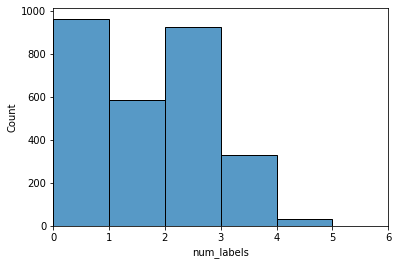

In [10]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [11]:
# view most common issue creators

issues_df.created_by.value_counts(ascending=False).head(10)

shamanez          31
erip              27
gaopengcuhk       20
ajesujoba         20
astariul          18
nicolabertoldi    17
travel-go         16
tuhinjubcse       16
munael            16
gvskalyan         15
Name: created_by, dtype: int64

In [12]:
# first find bots transparently tagged as such


def is_bot(name):
    return name[-5:] == "[bot]"


all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print("bots found:")
for b in bots:
    print("\t", b)

bots found:


In [13]:
# choose any additional bot accounts whose issues to not count

additional_bots = ["sesheta"]

In [14]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]

In [15]:
# most popular labels, nearly finalized

cutoff = 50
final_labels = []

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")
        final_labels.append(a)

question 1178
needs triage 987
stale 463
kind/bug 401
enhancement 167
help wanted 146
documentation 85


In [16]:
# choose labels whose issues you don't want to include in the dset

exclude = []

In [17]:
# remove those labels

for lbl in exclude:
    if lbl in final_labels:
        final_labels.remove(lbl)


def inclusion(lbl_list):
    if type(lbl_list) == str:
        return not any([lbl in lbl_list.split("\t") for lbl in exclude])
    else:
        return True


not_containing = issues_df.labels.apply(lambda x: inclusion(x))
issues_df = issues_df[not_containing]

In [18]:
# choose issues you do not wish to attempt to predict

# dont_pred = ['priority/P2', 'lifecycle/frozen', 'lifecycle/stale', 'priority/P3', 'priority/P1', 'lifecycle/rotten']

dont_pred = []

for dp in dont_pred:
    final_labels.remove(dp)

(0.0, 6.0)

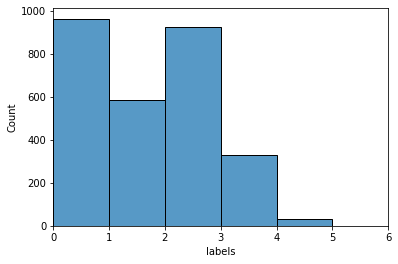

In [19]:
# output histogram of number of relevant labels, finalized

set_dp = set(dont_pred)

num_rel_issues = issues_df.labels.apply(
    lambda x: len(set(x.split("\t")).difference(set_dp)) if type(x) == str else 0
)

ax = sns.histplot(num_rel_issues, bins=int(max(num_rel_issues)))
ax.set_xlim((0, 6))

In [20]:
# preprocessing
issues_df = issues_df.fillna({"title": "", "body": ""})
issues_df["body"] = issues_df["body"].apply(
    lambda x: x.replace("\n", " <N> ").replace("\r", " <R> ")
)
issues_df["input"] = issues_df["title"] + " <SEP> " + issues_df["body"]

In [21]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    labelled = issues_df[~issues_df.labels.isna()]
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labelled[labelled.labels.apply(lambda x: label in x.split("\t"))]
    n = len(pos_samples)
    remaining = labelled[labelled.id.apply(lambda x: label not in x.split("\t"))]
    n_neg = 0
    per_label = n // len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining[remaining.labels.apply(lambda x: lbl in x.split("\t"))]
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            if i != len(final_labels_) - 1:
                per_label = (n - n_neg) // (len(final_labels_) - i - 1)
        remaining = remaining[
            remaining.labels.apply(lambda x: lbl not in x.split("\t"))
        ]
        neg_ids = neg_ids.union(set(neg_samples.id))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_samples) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_samples) - len(neg_ids):
            neg_ids = neg_ids.union(
                set(unlabelled.sample(len(pos_samples) - len(neg_ids)).id)
            )
        else:
            neg_ids = neg_ids.union(set(unlabelled.ids))
            pos_samples = pos_samples.sample(len(neg_ids))
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)].input
    x = np.concatenate((final_neg_samples.values, pos_samples.input.values)).reshape(
        -1, 1
    )
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(pos_samples))))
    return x, y.astype(int)

In [22]:
def predict_label(label, k=5):
    """
    validates fastText model on the given label, using k-fold cross validation
    """
    x, y = get_subdataset(label)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    accuracy = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(x):
        model = FirstColFtClassifier()
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        accuracy.append(np.mean(preds == y_test))
        precision_ = preds[preds == 1] == y_test[preds == 1]
        if len(precision_) != 0:
            precision.append(np.mean(precision_))
        recall_ = preds[y_test == 1] == y_test[y_test == 1]
        if len(recall_) != 0:
            recall.append(np.mean(recall_))
    cols = ["label", "n", "accuracy", "precision", "recall"]
    data = [label, len(x), np.mean(accuracy), np.mean(precision), np.mean(recall)]
    return pd.DataFrame([data], columns=cols)

In [23]:
predicted_labels = []
for label in final_labels:
    predicted_labels.append(predict_label(label))

NOTE: for now, labels with a low amount of samples are very biased towards predicting a 0, or a negative prediction. This could be fixed by adjusting hyperparameters (once they are explored) and/or finetuning on a pretrained model.

In [24]:
# save and print the validation results

results_df = pd.concat(predicted_labels).sort_values("n", ascending=False)

results_df

,label,n,accuracy,precision,recall
0,question,2356,0.503400,0.425968,0.275684
0,needs triage,1974,0.505564,0.519305,0.409702
0,stale,926,0.507585,0.500496,0.280010
0,kind/bug,802,0.556110,0.530213,0.972898
0,enhancement,334,0.496834,0.000000,0.000000
0,help wanted,292,0.496844,0.578070,0.245161
0,documentation,170,0.488235,0.333333,0.046053


In [25]:
# set conditions for saving the model of a potential label

min_accuracy = 0.55

min_precision = 0.6

min_recall = 0.0

# add in the labels you want to have a model for anyway

# addins = ['kind/bug', 'kind/feature']

addins = []

condition1 = results_df.accuracy > min_accuracy
condition2 = results_df.precision > min_precision
cond = condition1 & condition2

to_save = results_df[cond | results_df.label.isin(addins)]

labels_to_save = to_save.label.values

to_save

,label,n,accuracy,precision,recall


In [26]:
if not os.path.exists("saved_models"):
    os.mkdir("saved_models")

if use_ceph:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = FirstColFtClassifier()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_") + ".bin")
        model.model.save_model(lbl_path)
        key = f"github_labeler/{lbl_path}"
        s3.upload_file(Bucket=s3_bucket, Key=key, Filename=lbl_path)
        os.remove(lbl_path)
else:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = FirstColFtClassifier()
        model.fit(X, y)
        model.model.save_model(
            os.path.join("saved_models", label.replace("/", "_") + ".bin")
        )

In [ ]:
# save information of who to ignore (so the app knows not to tag these issues)

with open("botlist.txt", "w") as f:
    for b in bots:
        f.write(b)
        f.write("\n")

# save label names

with open("labellist.txt", "w") as f:
    for b in labels_to_save:
        f.write(b)
        f.write("\n")

if use_ceph:
    s3.upload_file(
        Bucket=s3_bucket, Key="github_labeler/botlist.txt", Filename="botlist.txt"
    )
    s3.upload_file(
        Bucket=s3_bucket, Key="github_labeler/labellist.txt", Filename="labellist.txt"
    )